In [1]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import numpy as np
from functools import reduce

In [2]:
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import Sequence, load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tensorflow as tf

In [3]:
from data_explorer import get_celebrities, get_tvt

In [4]:
epochs = 10
batch_size = 32
num_classes = 80
margin = 1

In [5]:
resnset50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

In [6]:
img_dir = "main_img/"
img_size = (178,218)

In [7]:
def visualize_pair(pair, pred=None):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  fig.suptitle('Sim: {}'.format(pair['Sim']), size=16)
  ax1.imshow(load_img(img_dir + pair['Image1']))
  ax1.set_axis_off()
  ax2.imshow(load_img(img_dir + pair['Image2']))
  ax2.set_axis_off()
  plt.show()

In [8]:
def pairs(df):
  def f(row):
    return [[row['Image'], df[df['Class']==row['Class']].sample(n=1).iloc[0,0], 1],
            [row['Image'], df[df['Class']!=row['Class']].sample(n=1).iloc[0,0], 0]]
  return pd.DataFrame(reduce(lambda x, y: x + y, df.apply(f,axis=1).to_list(), []),
                      columns=['Image1','Image2','Sim'])

In [9]:
identity_df, rest = get_celebrities(num_classes, refactor_class=True)
identity_df = identity_df[["Image_name", "Class"]].rename(columns={"Image_name": "Image"})
identity_df.head()

,Image,Class
0,000001.jpg,79
1,000096.jpg,8
2,000116.jpg,14
3,000150.jpg,9
4,000404.jpg,79


In [10]:
train_df, val_df, test_df = get_tvt(identity_df, "Class", 0.8)

In [11]:
pairsTrain = pairs(train_df)
pairsVal = pairs(val_df)
pairsTest = pairs(test_df)

In [12]:
pairsTrain.head()

,Image1,Image2,Sim
0,029666.jpg,125720.jpg,1
1,029666.jpg,020315.jpg,0
2,119852.jpg,074185.jpg,1
3,119852.jpg,122067.jpg,0
4,076409.jpg,060141.jpg,1


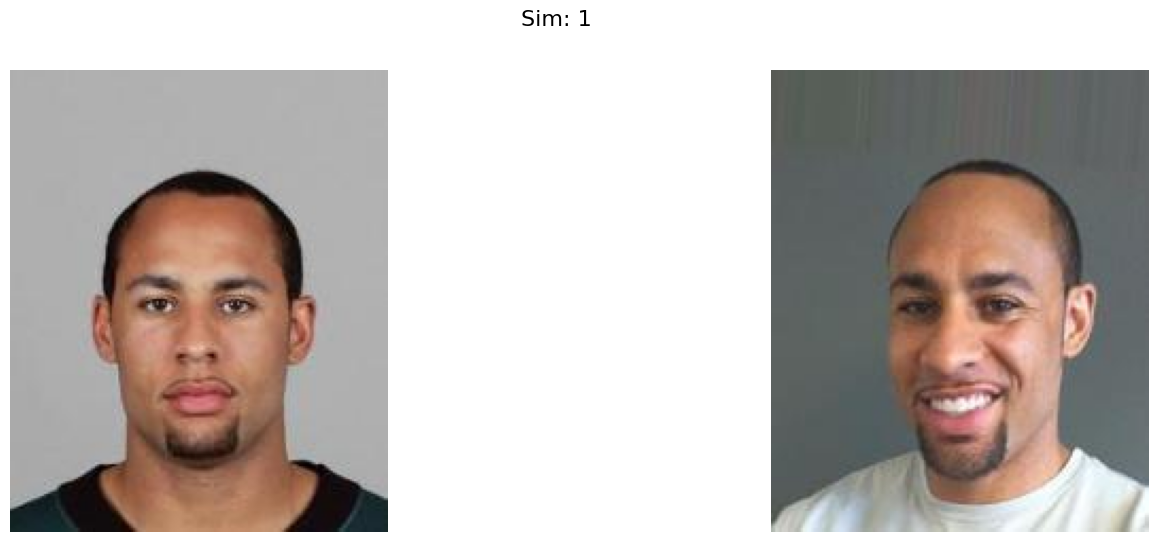

In [13]:
visualize_pair(pairsTrain.loc[0])

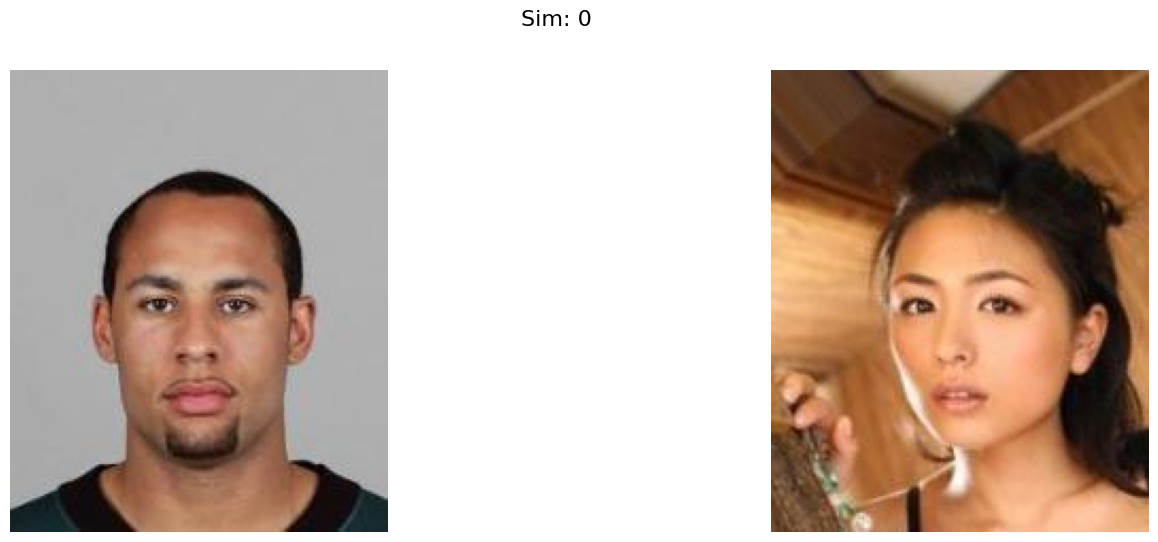

In [14]:
visualize_pair(pairsTrain.loc[1])

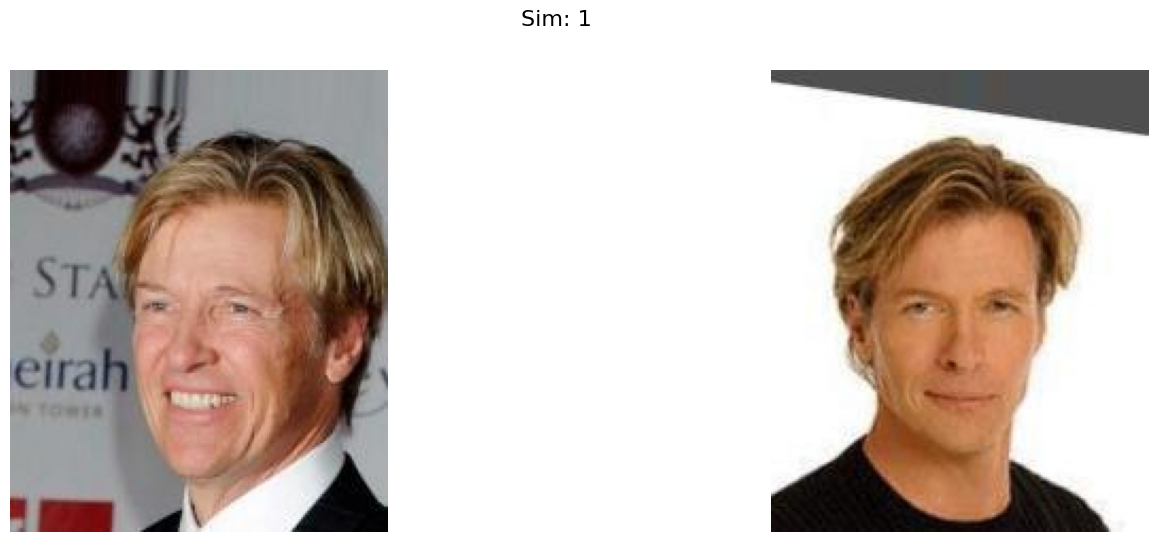

In [15]:
visualize_pair(pairsTrain.loc[pairsTrain.shape[0]-2])

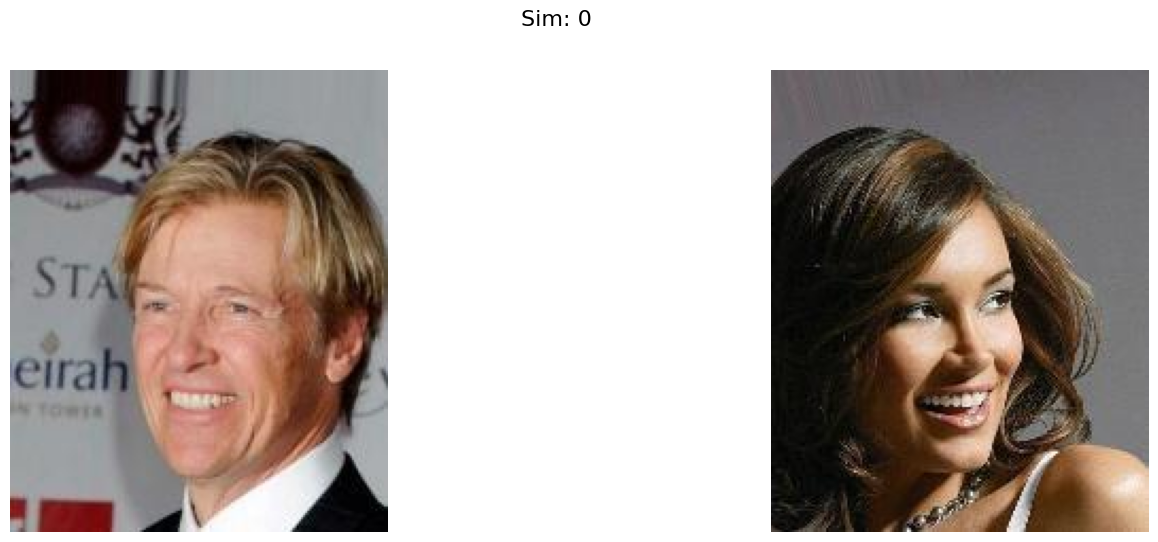

In [16]:
visualize_pair(pairsTrain.loc[pairsTrain.shape[0]-1])

In [17]:
class DataGenerator(Sequence):
  def __init__(self, df, batch_size=32, img_size=(200,200), img_dir= './', shuffle=True):
    self.batch_size = batch_size
    self.img_size = img_size
    self.img_dir = img_dir
    self.df = df
    self.indices = self.df.index.tolist()
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return len(self.indices) // self.batch_size

  def __getitem__(self, index):
    index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
    batch = [self.indices[k] for k in index]
    
    X1, X2, y = self.__get_data(batch)
    return [X1, X2], y

  def on_epoch_end(self):
    self.index = np.arange(len(self.indices))
    if self.shuffle:
      np.random.shuffle(self.index)

  def __get_data(self, batch):
    X1 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    X2 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    y = np.zeros((self.batch_size,), dtype="float32")
    for i, idx in enumerate(batch):
      X1[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image1'], target_size=self.img_size))
      X2[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image2'], target_size=self.img_size))
      y[i] = 1 - self.df.loc[idx,'Sim']
    return X1, X2, y

In [18]:
trainGenerator = DataGenerator(pairsTrain, batch_size=batch_size, img_size=img_size, img_dir=img_dir)
valGenerator = DataGenerator(pairsVal, batch_size=batch_size, img_size=img_size, img_dir=img_dir)
testGenerator = DataGenerator(pairsTest, batch_size=1, img_size=img_size, img_dir=img_dir, shuffle=False)

In [19]:
class EuclideanDLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, x, y):
        sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
        return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [20]:
pretrained_base = hub.KerasLayer(resnset50, trainable = False)

In [21]:
input = layers.Input(img_size + (3,))
x = layers.Rescaling(1./255)(input)
x = pretrained_base(x)
x = layers.Flatten()(x)
embedding_network = Model(input, x)

input_1 = layers.Input(img_size + (3,))
input_2 = layers.Input(img_size + (3,))

In [22]:
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

siamese_layer = EuclideanDLayer()
siamese_layer._name = 'distance'

distance = siamese_layer(tower_1, tower_2)

#merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
features = layers.BatchNormalization()(distance)
features = layers.Dense(512, activation="relu")(features)
features = layers.Dropout(0.2)(features)
features = layers.Dense(128, activation="relu")(features)
features = layers.Dropout(0.2)(features)
features = layers.Dense(32, activation="relu")(features)
output_layer = layers.Dense(1, activation="sigmoid")(features)

In [23]:
siamese = Model(inputs=[input_1, input_2], outputs=output_layer)

In [24]:
def loss(margin=1.0):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [25]:
siamese.compile(loss=loss(margin=margin), optimizer="adam", metrics=["accuracy"])

In [26]:
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 178, 218, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 178, 218, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 1001)         25615849    ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [27]:
callbacks = [ModelCheckpoint('./Weights/best.test_8',
             save_best_only=True)]

In [28]:
history = siamese.fit(trainGenerator,
                    validation_data = valGenerator,
                    callbacks=callbacks,
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/10
  2/121 [..............................] - ETA: 5:47 - loss: 0.2474 - accuracy: 0.5781 

KeyboardInterrupt: 

In [ ]:
siamese.evaluate(testGenerator)

In [ ]:
siamese.save('./models/Final.test_8')

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model loss', size=20)
ax1.set_ylabel('Loss', size=16)
ax1.set_xlabel('Epoch', size=16)
ax1.set_xticks(range(0, 6, 25))
ax1.legend(['Train', 'Validation'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Classification accuracy', size=20)
ax2.set_ylabel('Accuracy', size=16)
ax2.set_xlabel('Epoch', size=16)
ax2.set_xticks(range(0, 6, 25))
ax2.legend(['Train', 'Validation'], loc='upper left')

fig.suptitle('Learning curves', size=20)

plt.show()

In [ ]:
pairsTest['Preds'] = siamese.predict(testGenerator)

In [ ]:
pairsTest.to_csv('Preds_test_8.txt')